In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# 구버전의 주피터 노트북에서 그래프가 보이는 설정
%matplotlib inline
import folium

In [2]:
pd.set_option('display.max_rows',None)

In [3]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

plt.rc("font", family=get_font_family())

# 데이터 불러오기

In [5]:
df = pd.read_excel("../data/서울시 어린이집 정보(위경도 업데이트).xlsx")
df.head()

,시군구명,어린이집코드,어린이집명,어린이집유형,운영현황,우편번호,상세주소,Latitude,Longitude,전화번호,...,교직원현황-보육교사,교직원현황-특수교사,교직원현황-치료교사,교직원현황-영양사,교직원현황-간호사,교직원현황-간호조무사,교직원현황-조리원,교직원현황-사무직원,교직원현황-총계,데이터수집일
0,관악구,11620000569,구립뉴포레어린이집,국공립,정상,8769.0,서울특별시 관악구 조원로 24 힐스테이트뉴포레아파트,37.483196,126.905064,02-000-0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04:48.0
1,구로구,11530000647,디지털꿈터어린이집,국공립,정상,8381.0,서울특별시 구로구 디지털로27길 36 1층 108호,37.483781,126.892564,02-838-5653,...,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,04:09.0
2,영등포구,11560000496,신길더샵해늘어린이집,국공립,정상,7361.0,서울특별시 영등포구 가마산로79길 37 관리동,37.507112,126.916856,02-0000-0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04:31.0
3,동작구,11590000462,구립신대방누리어린이집,국공립,정상,7074.0,서울특별시 동작구 신대방1다길 19 1층,37.491710,126.925366,010-5658-1031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19:39.0
4,은평구,11380000687,구립 북한산힐스솔숲어린이집,국공립,정상,3366.0,서울특별시 은평구 불광로2길 33 북한산힐스테이트1차아파트 단지 내,37.612612,126.936695,010-2078-5778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03:19.0


# 어린이집 수 / 비율

In [18]:
df = df[(df['운영현황'] == "정상")|(df['운영현황'] == "재개")]
df.shape

(4866, 62)

In [58]:
# 모든 어린이집 유형 포함?
df_count = df.groupby('시군구명')['어린이집유형'].count().to_frame()
df_count

,어린이집유형
시군구명,
강남구,189
강동구,242
강북구,128
강서구,322
관악구,192
광진구,154
구로구,269
금천구,135
노원구,324


In [59]:
df_count = df_count.reset_index()

In [62]:
df_count.columns
df_count.columns = ['시군구명','어린이집 수']

In [74]:
df2 = df.groupby(['시군구명','어린이집유형'])['어린이집명'].count().to_frame()
df2

어린이집명
시군구명 어린이집유형       
강남구  가정         37
     국공립        69
     민간         46
     직장         36
     협동          1
...            ...
중랑구  국공립        79
     민간         63
     법인?단체등      5
     직장          3
     협동          1

[150 rows x 1 columns]

In [76]:
df2 = df2.reset_index()

In [77]:
df2.columns

Index(['시군구명', '어린이집유형', '어린이집명'], dtype='object')

In [79]:
df2.columns = ['시군구명','어린이집유형','어린이집유형수']
df2

,시군구명,어린이집유형,어린이집유형수
0,강남구,가정,37
1,강남구,국공립,69
2,강남구,민간,46
3,강남구,직장,36
4,강남구,협동,1
...,...,...,...
145,중랑구,국공립,79
146,중랑구,민간,63
147,중랑구,법인?단체등,5
148,중랑구,직장,3


In [103]:
df3 = pd.merge(df2,df_count, how = 'outer', on = '시군구명')

In [104]:
df3['비율'] = df3['어린이집유형수'] / df3['어린이집 수']

In [106]:
df3 = df3[df3['어린이집유형'].str.contains('가정|국공립|민간')]

In [110]:
df3.head(5)

,시군구명,어린이집유형,어린이집유형수,어린이집 수,비율
0,강남구,가정,37,189,0.195767
1,강남구,국공립,69,189,0.365079
2,강남구,민간,46,189,0.243386
5,강동구,가정,80,242,0.330579
6,강동구,국공립,87,242,0.359504


## 어린이집 표준데이터 어린이집 수 / 비율 데이터

In [108]:
df3.groupby(['시군구명','어린이집유형']).mean()

어린이집유형수  어린이집 수        비율
시군구명 어린이집유형                           
강남구  가정         37.0   189.0  0.195767
     국공립        69.0   189.0  0.365079
     민간         46.0   189.0  0.243386
강동구  가정         80.0   242.0  0.330579
     국공립        87.0   242.0  0.359504
     민간         67.0   242.0  0.276860
강북구  가정         22.0   128.0  0.171875
     국공립        60.0   128.0  0.468750
     민간         39.0   128.0  0.304688
강서구  가정        122.0   322.0  0.378882
     국공립        93.0   322.0  0.288820
     민간         80.0   322.0  0.248447
관악구  가정         50.0   192.0  0.260417
     국공립        86.0   192.0  0.447917
     민간         45.0   192.0  0.234375
광진구  가정         38.0   154.0  0.246753
     국공립        57.0   154.0  0.370130
     민간         54.0   154.0  0.350649
구로구  가정         94.0   269.0  0.349442
     국공립        99.0   269.0  0.368030
     민간         58.0   269.0  0.215613
금천구  가정         22.0   135.0  0.162963
     국공립        60.0   135.0  0.444444
     민간         35.0   135.0  0.259259
노원구  가정        169.0   324.0  0.521605
     국공립       107.0   324.0  0.330247
     민간         39.0   324.0  0.120370
도봉구  가정         55.0   174.0  0.316092
     국공립        66.0   174.0  0.379310
     민간         46.0   174.0  0.264368
동대문구 가정         53.0   192.0  0.276042
     국공립        85.0   192.0  0.442708
     민간         43.0   192.0  0.223958
동작구  가정         53.0   184.0  0.288043
     국공립        83.0   184.0  0.451087
     민간         37.0   184.0  0.201087
마포구  가정         51.0   193.0  0.264249
     국공립        87.0   193.0  0.450777
     민간         28.0   193.0  0.145078
서대문구 가정         33.0   134.0  0.246269
     국공립        62.0   134.0  0.462687
     민간         31.0   134.0  0.231343
서초구  가정         36.0   173.0  0.208092
     국공립        90.0   173.0  0.520231
     민간         22.0   173.0  0.127168
성동구  가정         43.0   161.0  0.267081
     국공립        89.0   161.0  0.552795
     민간         18.0   161.0  0.111801
성북구  가정         62.0   213.0  0.291080
     국공립        89.0   213.0  0.417840
     민간         41.0   213.0  0.192488
송파구  가정        119.0   338.0  0.352071
     국공립       109.0   338.0  0.322485
     민간         86.0   338.0  0.254438
양천구  가정        103.0   245.0  0.420408
     국공립        95.0   245.0  0.387755
     민간         37.0   245.0  0.151020
영등포구 가정         64.0   232.0  0.275862
     국공립        89.0   232.0  0.383621
     민간         41.0   232.0  0.176724
용산구  가정         33.0   108.0  0.305556
     국공립        37.0   108.0  0.342593
     민간         17.0   108.0  0.157407
은평구  가정         37.0   216.0  0.171296
     국공립        90.0   216.0  0.416667
     민간         78.0   216.0  0.361111
종로구  가정          2.0    73.0  0.027397
     국공립        34.0    73.0  0.465753
     민간          5.0    73.0  0.068493
중구   가정          9.0    67.0  0.134328
     국공립        27.0    67.0  0.402985
     민간          3.0    67.0  0.044776
중랑구  가정         57.0   208.0  0.274038
     국공립        79.0   208.0  0.379808
     민간         63.0   208.0  0.302885

# 출생률

In [202]:
data = pd.read_csv('../data/출생률.txt', sep = "\t",engine='python')
data.head(5)

,기간,지역,출생,출생.1,사망,사망.1
0,기간,지역,출생건수(명),조출생률,사망건수(명),조사망률
1,2020,합계,47445,5,45522,4.8
2,2020,종로구,529,3.7,867,6
3,2020,중구,690,5.7,723,5.9
4,2020,용산구,1176,5.4,1145,5.2


In [203]:
data.columns = ['기간','시군구명','출생건수','조출생률','사망건수','조사망률']

In [204]:
data = data.drop(0, axis=0)
data = data.drop(['기간'],axis=1)

In [205]:
data['출생건수'] = data['출생건수'].astype(int)
data['사망건수'] = data['사망건수'].astype(int)


In [206]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 1 to 26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시군구명    26 non-null     object 
 1   출생건수    26 non-null     int32  
 2   조출생률    26 non-null     float64
 3   사망건수    26 non-null     int32  
 4   조사망률    26 non-null     float64
dtypes: float64(2), int32(2), object(1)
memory usage: 964.0+ bytes


In [209]:
df = data.loc[2:]
df_prac1 = df.groupby(['시군구명'])['출생건수'].mean().to_frame().sort_values(by = '출생건수')
df_prac2 = df.groupby(['시군구명'])['조출생률'].mean().to_frame().sort_values(by = '조출생률')
df_prac3 = df.groupby(['시군구명'])['사망건수'].mean().to_frame().sort_values(by = '사망건수')
df_prac4 = df.groupby(['시군구명'])['조사망률'].mean().to_frame().sort_values(by = '조사망률')

## 출생,사망 관련 시각화

<AxesSubplot:xlabel='시군구명', ylabel='조사망률'>

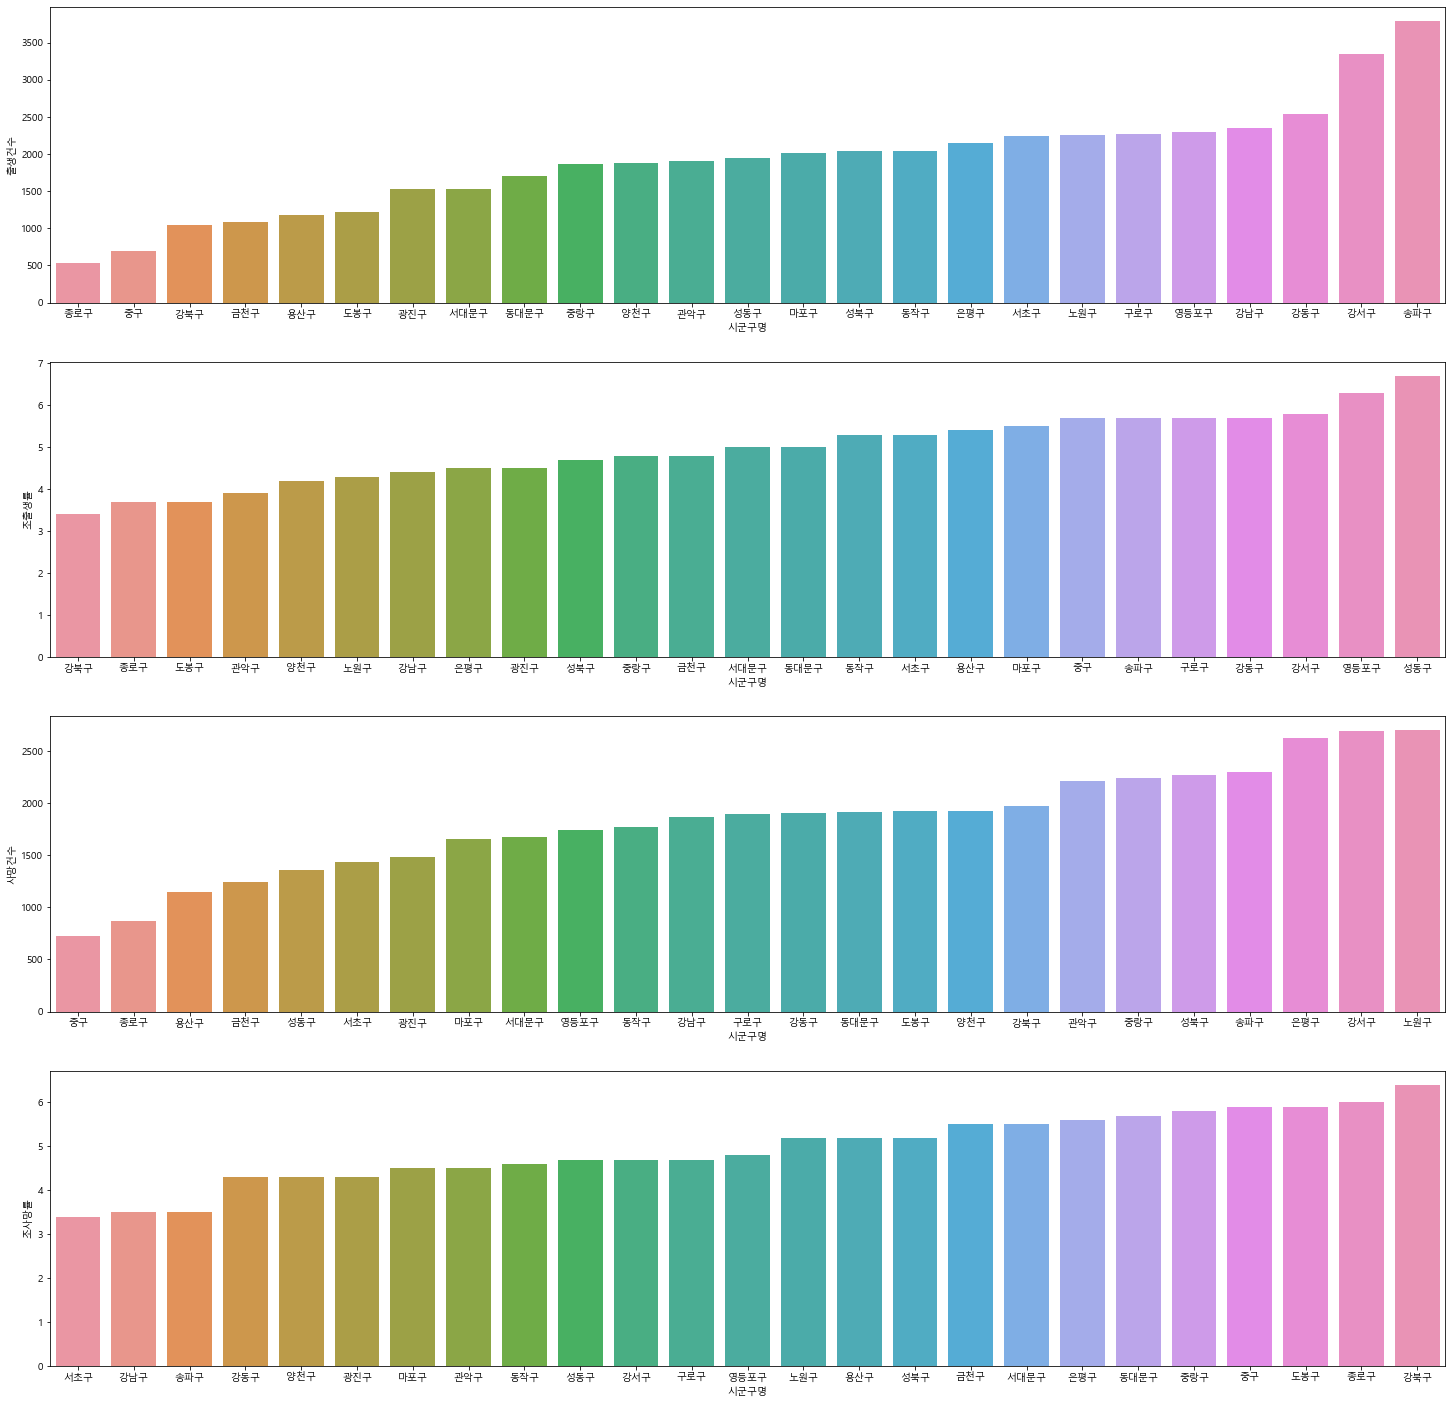

In [208]:
fig, ax = plt.subplots( nrows=4,  figsize=(25,25))
sns.barplot(data = df_prac1 , x =df_prac1.index,y="출생건수",ax= ax[0])
sns.barplot(data = df_prac2 , x =df_prac2.index,y="조출생률", ax=ax[1])
sns.barplot(data = df_prac3 , x =df_prac3.index,y="사망건수",ax=ax[2])
sns.barplot(data = df_prac4 , x =df_prac4.index,y="조사망률",ax=ax[3])

In [184]:
merge_data = data.loc[2:]
merge_data.head()

,시군구명,출생건수,조출생률,사망건수,조사망률
2,종로구,529,3.7,867,6
3,중구,690,5.7,723,5.9
4,용산구,1176,5.4,1145,5.2
5,성동구,1945,6.7,1363,4.7
6,광진구,1532,4.5,1486,4.3


In [133]:
df4 = pd.merge(df3,merge_data, how = 'left', on = '시군구명')

In [134]:
df4

,시군구명,어린이집유형,어린이집유형수,어린이집 수,비율,출생건수,조출생률,사망건수,조사망률
0,강남구,가정,37,189,0.195767,2356,4.4,1867,3.5
1,강남구,국공립,69,189,0.365079,2356,4.4,1867,3.5
2,강남구,민간,46,189,0.243386,2356,4.4,1867,3.5
3,강동구,가정,80,242,0.330579,2535,5.7,1901,4.3
4,강동구,국공립,87,242,0.359504,2535,5.7,1901,4.3
5,강동구,민간,67,242,0.276860,2535,5.7,1901,4.3
6,강북구,가정,22,128,0.171875,1049,3.4,1968,6.4
7,강북구,국공립,60,128,0.468750,1049,3.4,1968,6.4
8,강북구,민간,39,128,0.304688,1049,3.4,1968,6.4
9,강서구,가정,122,322,0.378882,3345,5.8,2694,4.7


# 서울시 보육교사 1인당 아동수

In [211]:
data = pd.read_csv('../data/서울시 보육교사 1인당 아동수.txt', sep = "\t",engine='python')
data.head(5)

,기간,지역,보육아동수,보육교사수,보육교사 1인당 아동수
0,2021,합계,"182,922","38,436",4.8
1,2021,종로구,"2,992",752,4.0
2,2021,중구,"2,976",728,4.1
3,2021,용산구,"4,108",871,4.7
4,2021,성동구,"5,876","1,268",4.6


In [212]:
data = data.drop(0, axis=0)
data = data.drop(['기간'],axis=1)

In [213]:
data.columns = ['시군구명','보육아동수','보육교사수','보육교사 1인당 아동수']

In [214]:
data['보육아동수'] = data['보육아동수'].str.replace(',', '').astype('int64')
data['보육교사수'] = data['보육교사수'].str.replace(',', '').astype('int64')

In [215]:
df_prac1 = data.groupby(['시군구명'])['보육아동수'].mean().to_frame().sort_values(by = '보육아동수')
df_prac2 = data.groupby(['시군구명'])['보육교사수'].mean().to_frame().sort_values(by = '보육교사수')
df_prac3 = data.groupby(['시군구명'])['보육교사 1인당 아동수'].mean().to_frame().sort_values(by = '보육교사 1인당 아동수')

<AxesSubplot:xlabel='시군구명', ylabel='보육교사 1인당 아동수'>

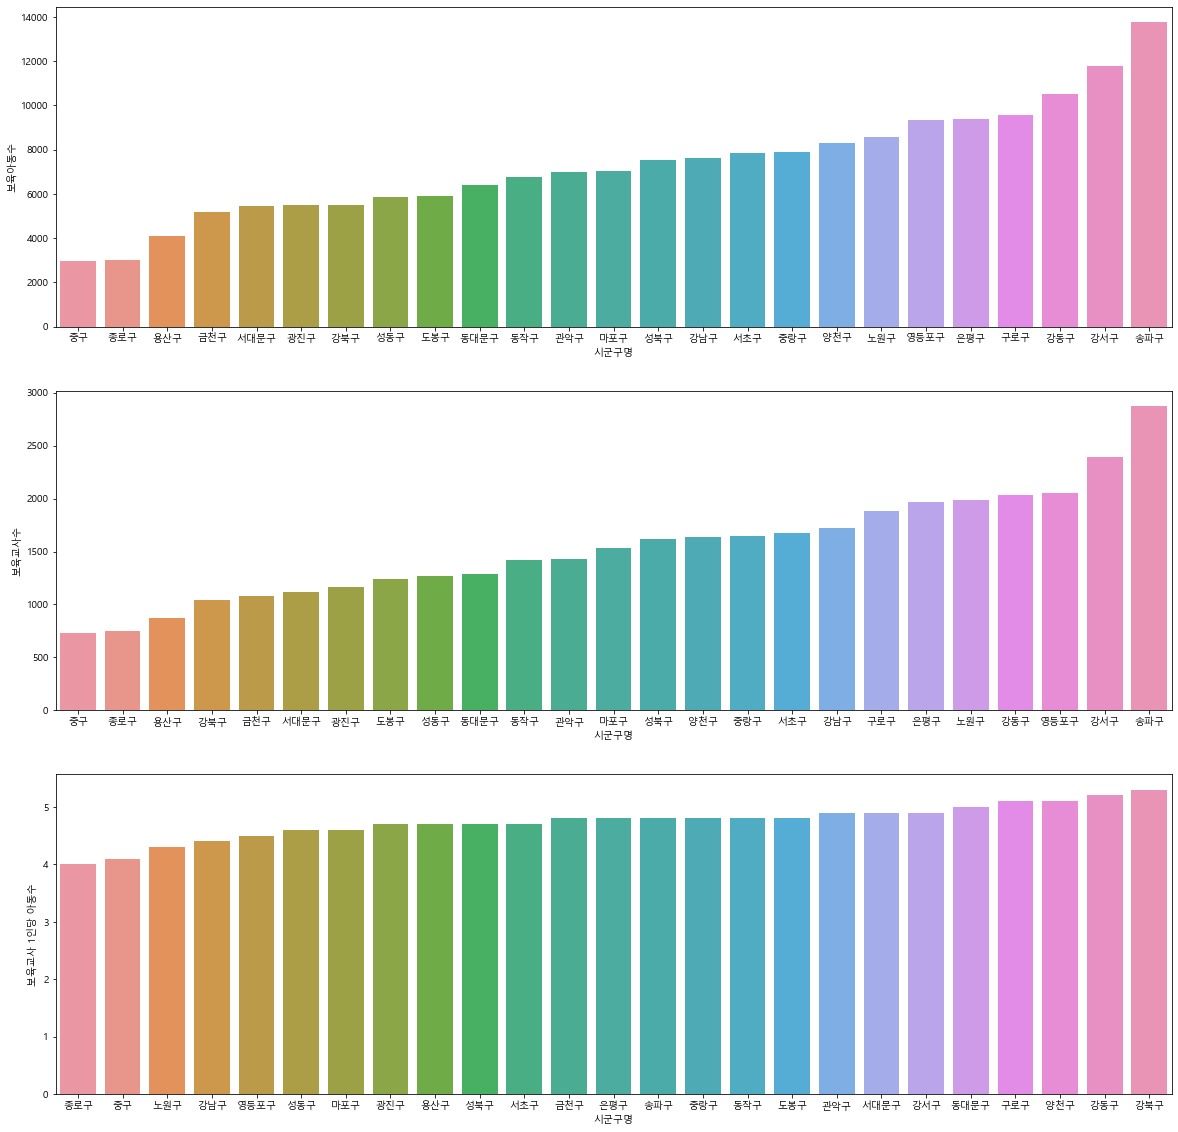

In [216]:
fig, ax = plt.subplots( nrows=3,  figsize=(20,20))
sns.barplot(data = df_prac1 , x = df_prac1.index, y="보육아동수", ax=ax[0])
sns.barplot(data = df_prac2 , x = df_prac2.index, y="보육교사수", ax=ax[1])
sns.barplot(data = df_prac3 , x = df_prac3.index, y="보육교사 1인당 아동수", ax=ax[2])

# 서울시 보육시설 이용 아동 비율

In [75]:
data = pd.read_csv('../data/서울시 보육시설 이용 아동 비율.txt', sep = "\t",engine='python')
data.head(5)

,기간,자치구별,전체보육아동수,국공립,국공립.1,사회복지법인,사회복지법인.1,법인·단체 등,법인·단체 등.1,민간,민간.1,가정,가정.1,부모협동,부모협동.1,직장,직장.1
0,기간,자치구별,전체보육아동수,아동수,이용비율,아동수,이용비율,아동수,이용비율,아동수,이용비율,아동수,이용비율,아동수,이용비율,아동수,이용비율
1,2021,합계,"182,922","85,501",46.7,"1,187",0.6,"3,873",2.1,"54,604",29.9,"23,846",13,661,0.4,"13,250",7.2
2,2021,종로구,"2,992","1,494",49.9,52,1.7,29,1,216,7.2,43,1.4,-,-,"1,158",38.7
3,2021,중구,"2,976","1,396",46.9,-,-,243,8.2,203,6.8,161,5.4,-,-,973,32.7
4,2021,용산구,"4,108","1,737",42.3,80,1.9,244,5.9,841,20.5,584,14.2,29,0.7,593,14.4


In [76]:
data = data.drop(0, axis=0)
data = data.drop(['기간'],axis=1)

In [93]:
data_pro = data.loc[:,'자치구별']

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 1 to 26
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   자치구별       26 non-null     object
 1   전체보육아동수    26 non-null     object
 2   국공립        26 non-null     object
 3   국공립.1      26 non-null     object
 4   사회복지법인     26 non-null     object
 5   사회복지법인.1   26 non-null     object
 6   법인·단체 등    26 non-null     object
 7   법인·단체 등.1  26 non-null     object
 8   민간         26 non-null     object
 9   민간.1       26 non-null     object
 10  가정         26 non-null     object
 11  가정.1       26 non-null     object
 12  부모협동       26 non-null     object
 13  부모협동.1     26 non-null     object
 14  직장         26 non-null     object
 15  직장.1       26 non-null     object
dtypes: object(16)
memory usage: 3.4+ KB


In [95]:
data_ratio = data.filter(regex='.1')
data_ratio = pd.concat([data_pro,data_ratio], axis = 1)
data_ratio.columns = ['자치구별','국공립','사회복지법인','법인·단체','민간','가정','부모협동','직장']

In [96]:
data_ratio = data_ratio.replace('-',0 )
data_ratio = data_ratio.fillna(0)

In [98]:
sns.barplot(data = data_ratio, x = '자치구별', )

,자치구별,국공립,사회복지법인,법인·단체,민간,가정,부모협동,직장
1,합계,46.7,0.6,2.1,29.9,13,0.4,7.2
2,종로구,49.9,1.7,1,7.2,1.4,0,38.7
3,중구,46.9,0,8.2,6.8,5.4,0,32.7
4,용산구,42.3,1.9,5.9,20.5,14.2,0.7,14.4
5,성동구,64.8,0,1.8,15.6,14.1,0,3.6
6,광진구,45.2,0,0,41,11.6,0.5,1.7
7,동대문구,48.5,0,2,31.3,15.4,0,2.9
8,중랑구,42,0,2.9,41.9,11.1,0.3,1.9
9,성북구,49.4,1.1,8.8,23.8,14.1,0.5,2.2
10,강북구,40.8,0.9,1.1,50.7,4.9,0.7,0.9


In [66]:
data = data.replace('-',0 )
data = data.fillna(0)

In [67]:
data['국공립'] = data['국공립'].str.replace(',','').astype('int64')

# 서울시 보육통계 어린이집 정원현원 충족률 현황(자치구,유형별)정보

In [7]:
# data2 = pd.read_csv('서울시 보육통계 어린이집 정원현원 충족률 현황(자치구,유형별)정보.csv', encoding = 'cp949')
data2.head()

,자치구명,구분명,소계,아동수_국공립,아동수_사회복지법인,아동수_법인단체등,아동수_민간,아동수_가정,아동수_직장
0,계,아동정원수,235682,103922,1690,5427,73175,29967,20642
1,강동,정원충족률,80.69%,85.88%,91.95%,81.21%,74.3%,86.27%,69.47%
2,강동,아동현원수,10521,4623,80,134,3970,1432,264
3,강동,아동정원수,13038,5383,87,165,5343,1660,380
4,송파,정원충족률,84.44%,88.97%,77.57%,87.07%,81.09%,87.39%,72.79%


In [6]:
data2 = data2[['자치구명','구분명','소계','아동수_국공립','아동수_사회복지법인','아동수_법인단체등','아동수_민간','아동수_가정','아동수_직장']].copy()

In [8]:
data2_count = data2[data2['구분명'] == "아동정원수"]
data2_count = data2_count.drop('구분명',axis=1)

In [10]:
data2_count.head()

,자치구명,소계,아동수_국공립,아동수_사회복지법인,아동수_법인단체등,아동수_민간,아동수_가정,아동수_직장
0,계,235682,103922,1690,5427,73175,29967,20642
3,강동,13038,5383,87,165,5343,1660,380
6,송파,16296,6444,107,116,5521,2553,1507
9,강남,10866,5099,0,0,2595,801,2302
12,서초,10474,5509,0,237,1731,747,2176


In [16]:
data2_melt = data2_count.melt(id_vars = ['자치구명','소계'], var_name = '유형')
data2_melt = data2_melt.drop(data2_melt.index[0])

In [21]:
data2_melt['소계'] = data2_melt['소계'].astype(float)
data2_melt['value'] = data2_melt['value'].astype(float)
data2_melt

,자치구명,소계,유형,value
1,강동,13038.0,아동수_국공립,5383.0
2,송파,16296.0,아동수_국공립,6444.0
3,강남,10866.0,아동수_국공립,5099.0
4,서초,10474.0,아동수_국공립,5509.0
5,관악,9442.0,아동수_국공립,4762.0
6,동작,8377.0,아동수_국공립,4327.0
7,영등포,11739.0,아동수_국공립,4522.0
8,금천,7369.0,아동수_국공립,2999.0
9,구로,12170.0,아동수_국공립,5135.0
10,강서,15122.0,아동수_국공립,5442.0


## 어린이집 정원 자치구별

<AxesSubplot:xlabel='자치구명'>

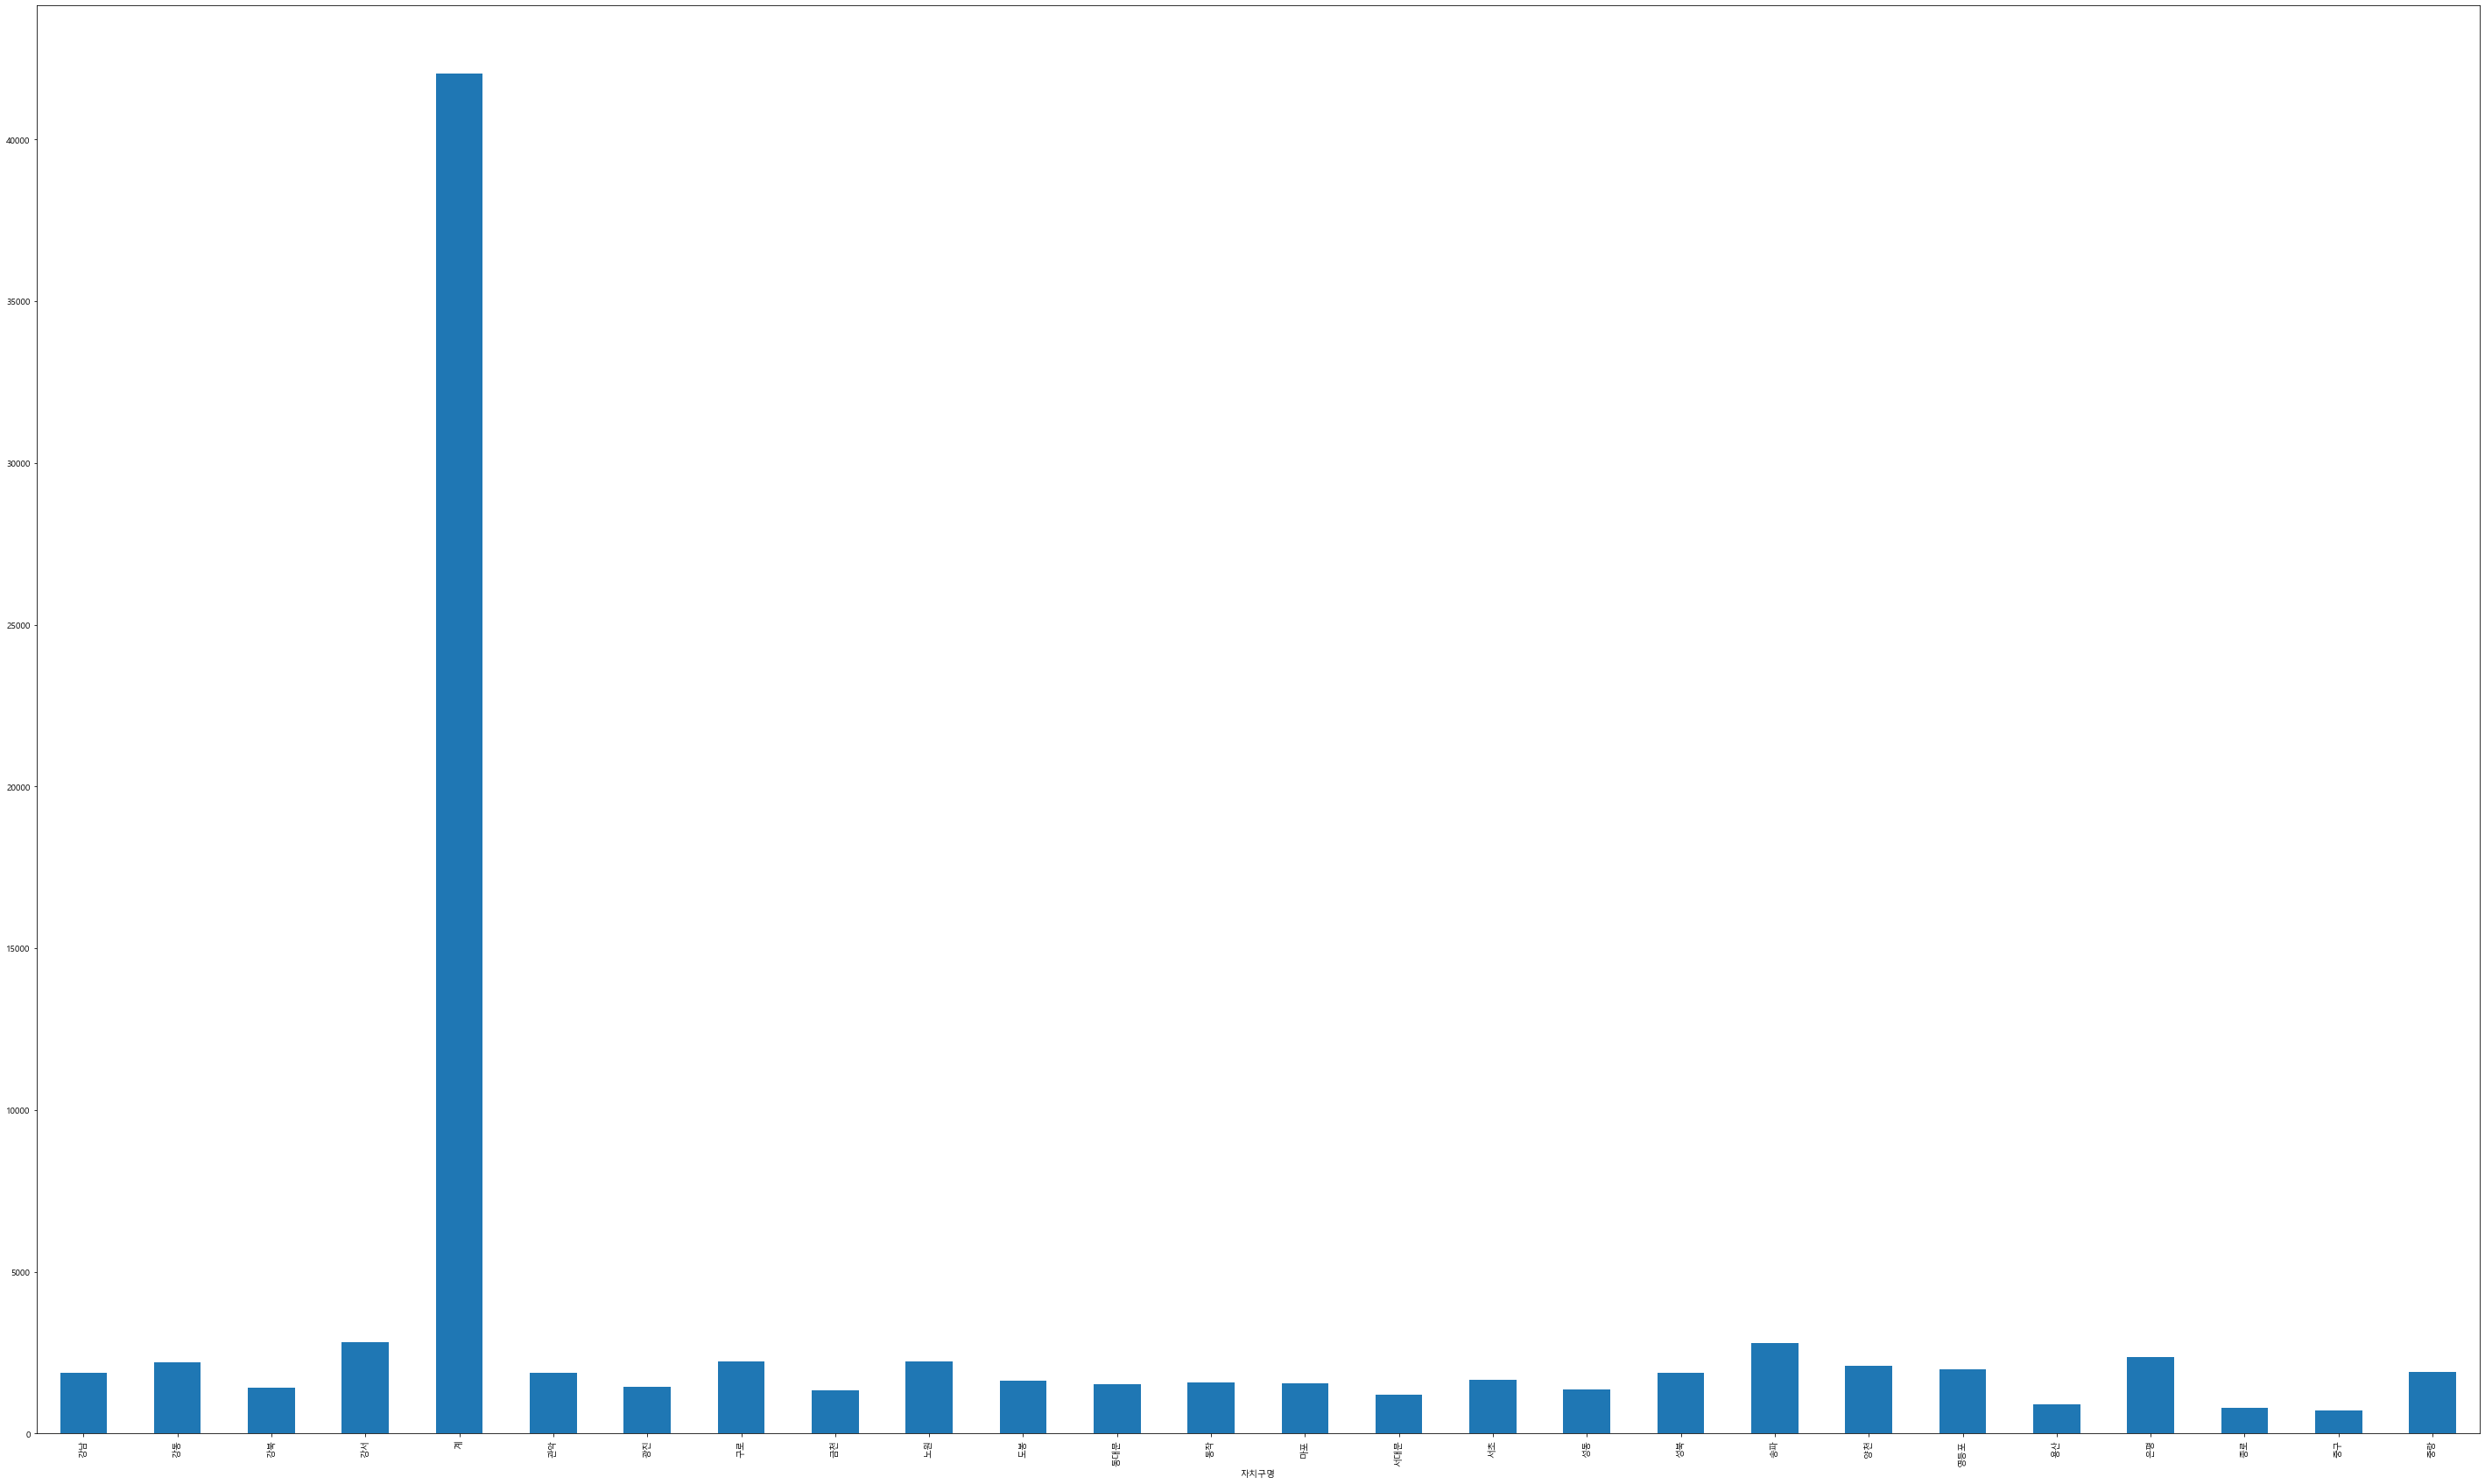

In [20]:
plt.figure(figsize=(50,30))
# plt.xtick.labelsize 
data2_melt.groupby(['자치구명'])['value'].mean().plot(kind = 'bar')

## 어린이집 정원 유형별

<AxesSubplot:xlabel='유형'>

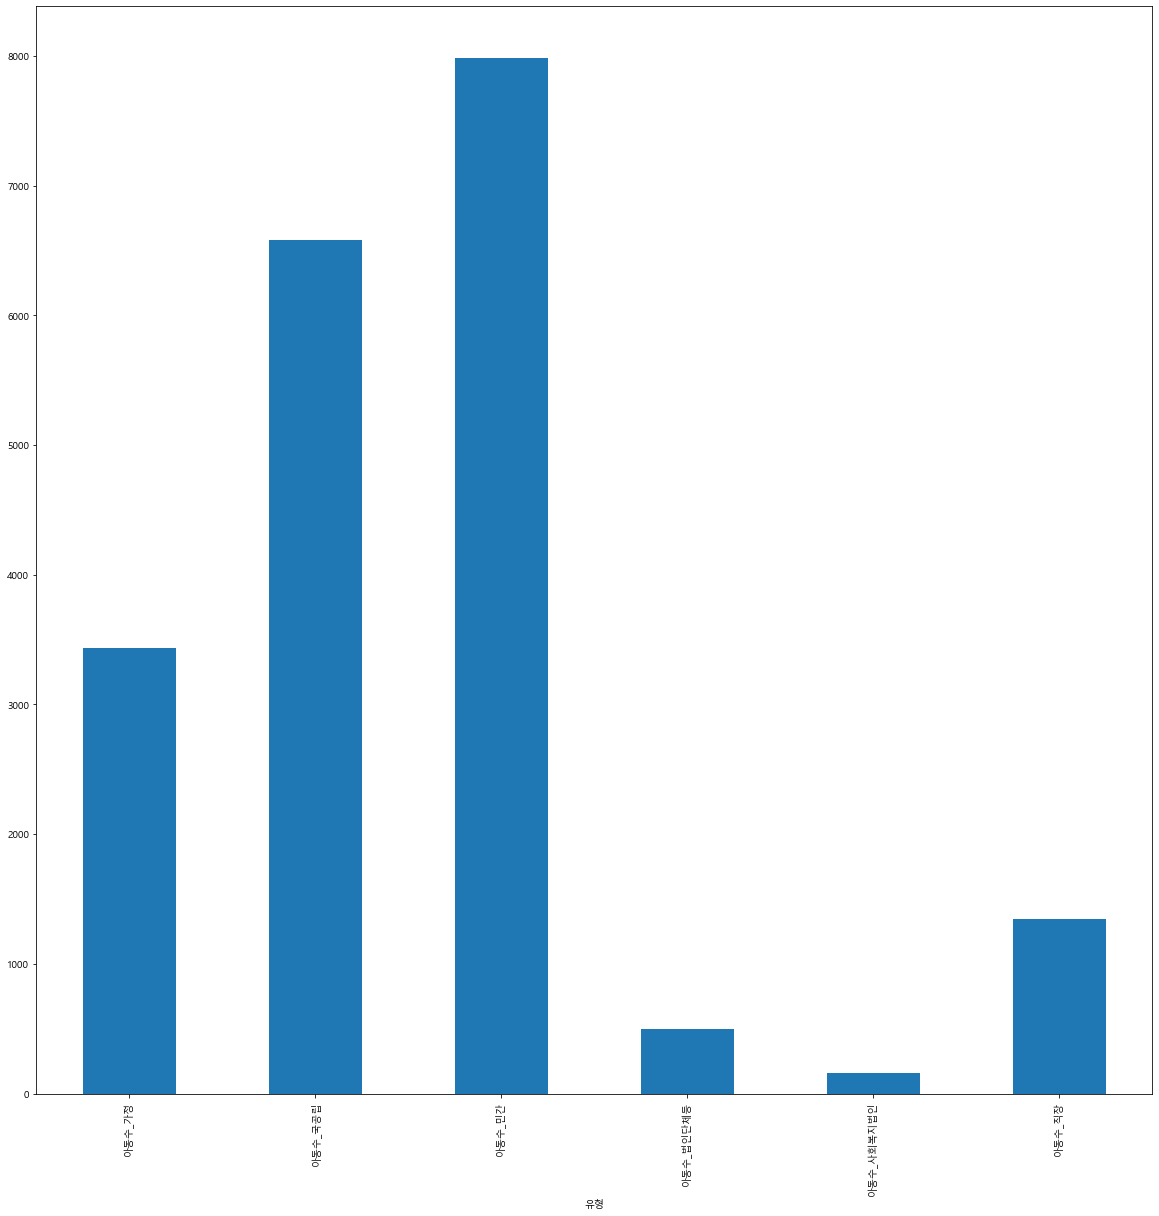

In [185]:
plt.figure(figsize=(20,20))
data2_melt.groupby(['유형'])['value'].mean().plot(kind = 'bar')

In [238]:
data2_count2 = data2[data2['구분명'] == "정원충족률"]
data2_count2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208 entries, 1 to 622
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   자치구명        208 non-null    object
 1   구분명         208 non-null    object
 2   소계          208 non-null    object
 3   아동수_국공립     208 non-null    object
 4   아동수_사회복지법인  208 non-null    object
 5   아동수_법인단체등   208 non-null    object
 6   아동수_민간      208 non-null    object
 7   아동수_가정      208 non-null    object
 8   아동수_직장      208 non-null    object
dtypes: object(9)
memory usage: 16.2+ KB


In [239]:
data2_count2 = data2_count2[['자치구명','아동수_국공립','아동수_사회복지법인','아동수_법인단체등','아동수_민간','아동수_가정','아동수_직장']].copy()
data2_count2

,자치구명,아동수_국공립,아동수_사회복지법인,아동수_법인단체등,아동수_민간,아동수_가정,아동수_직장
1,강동,85.88%,91.95%,81.21%,74.3%,86.27%,69.47%
4,송파,88.97%,77.57%,87.07%,81.09%,87.39%,72.79%
7,강남,76.39%,0.%,0.%,72.02%,80.52%,50.87%
10,서초,79.54%,0.%,74.26%,72.5%,88.76%,60.66%
13,관악,79.61%,2.44%,63.47%,71.23%,70.97%,67.42%
16,동작,84.49%,26.98%,55.45%,78.18%,81.91%,68.03%
19,영등포,87.64%,62.6%,62.12%,73.88%,87.22%,70.66%
22,금천,76.06%,76.68%,63.72%,67.14%,74.42%,48.35%
25,구로,87.22%,75.27%,68.98%,71.17%,78.63%,59.13%
28,강서,83.04%,92.49%,66.76%,73.36%,79.61%,74.13%


In [240]:
data2_melt2 = data2_count2.melt(id_vars = ['자치구명'], var_name = '유형')

In [241]:
data2_melt2['value'] = data2_melt2['value'].str.replace('%','').astype(float)

## 자치구별 충족률

In [235]:
plt.figure(figsize=(20,20))
data2_melt3 = data2_melt2.groupby(['자치구명'])['value'].mean().to_frame().sort_values(by = ['value'])

<Figure size 1440x1440 with 0 Axes>

<AxesSubplot:title={'center':'자치구별 충족률'}, xlabel='자치구명', ylabel='value'>

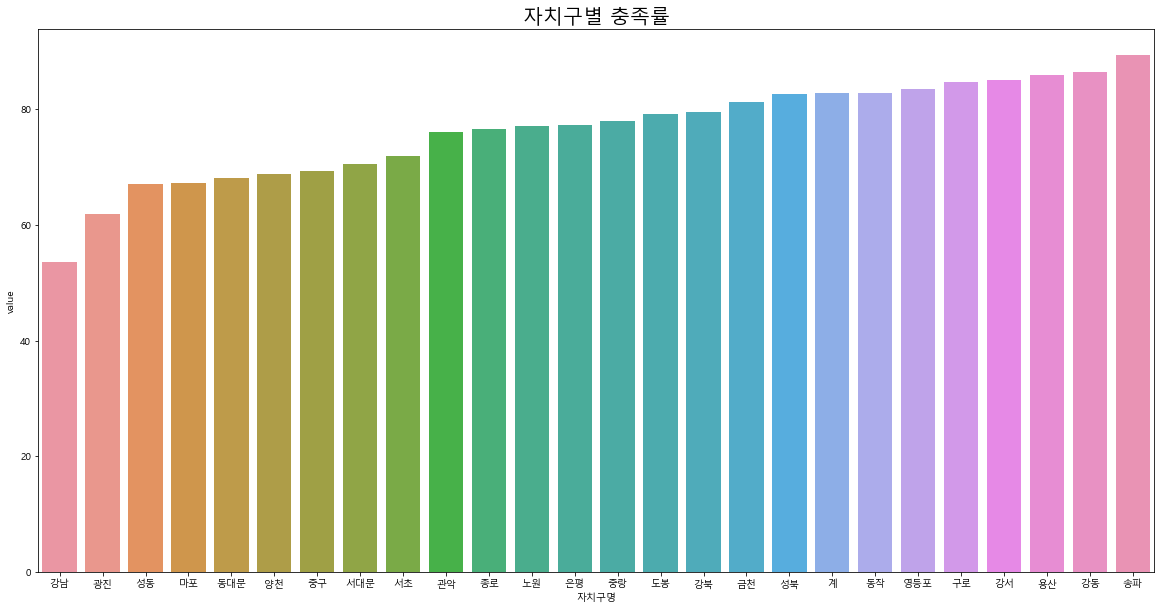

In [236]:
plt.figure(figsize=(20,10))
plt.title('자치구별 충족률',fontsize = 20)
sns.barplot(data = data2_melt3 , x =data2_melt3.index,y="value")

## 유형별 충족률

In [243]:
plt.figure(figsize=(20,20))
data2_melt4 = data2_melt2.groupby(['유형'])['value'].mean().to_frame().sort_values(by = ['value'])

<Figure size 1440x1440 with 0 Axes>

<AxesSubplot:title={'center':'유형별 충족률'}, xlabel='유형', ylabel='value'>

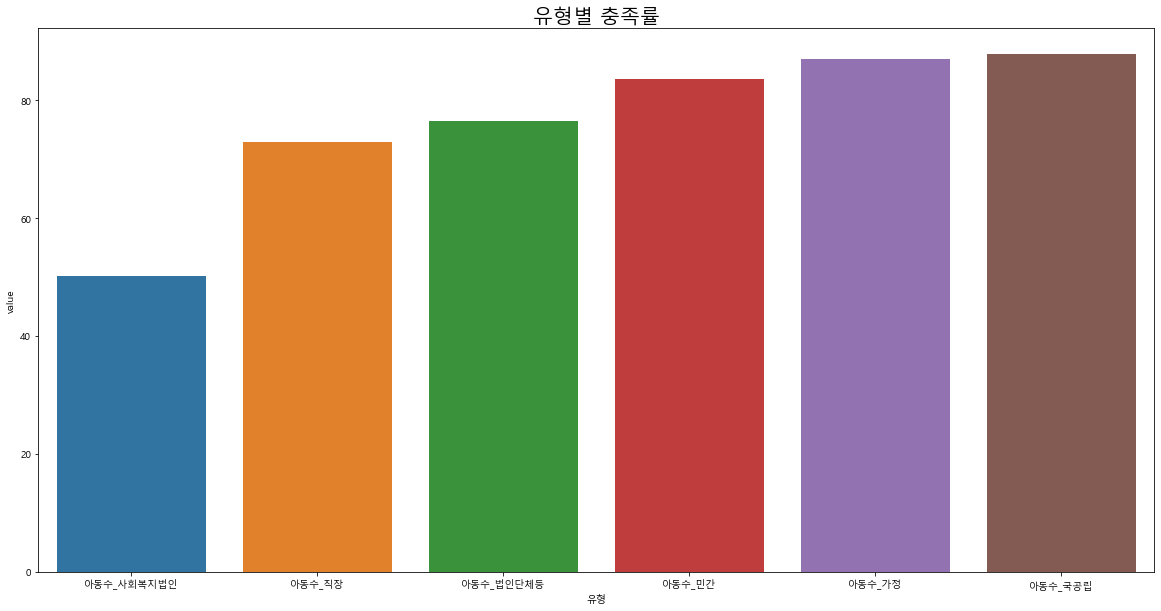

In [245]:
plt.figure(figsize=(20,10))
plt.title('유형별 충족률',fontsize = 20)
sns.barplot(data = data2_melt4 , x =data2_melt4.index,y="value")

In [259]:
data2_melt5 = data2_melt2.groupby(['자치구명','유형'])['value'].mean().to_frame().sort_values(by = ['value'])
data2_melt5

value
자치구명 유형                  
성동   아동수_사회복지법인   0.00000
서대문  아동수_사회복지법인   0.00000
광진   아동수_사회복지법인   0.00000
강남   아동수_법인단체등    0.00000
     아동수_사회복지법인   0.00000
양천   아동수_사회복지법인   0.00000
중구   아동수_사회복지법인   0.00000
동대문  아동수_사회복지법인   0.00000
마포   아동수_사회복지법인   0.00000
서초   아동수_사회복지법인   0.00000
중랑   아동수_사회복지법인  37.06125
관악   아동수_사회복지법인  44.58625
광진   아동수_법인단체등   46.75625
노원   아동수_법인단체등   50.00000
은평   아동수_사회복지법인  54.11000
강남   아동수_직장      64.89500
종로   아동수_사회복지법인  65.44875
강북   아동수_직장      65.79875
광진   아동수_직장      67.31125
마포   아동수_직장      68.38125
금천   아동수_직장      68.44000
성동   아동수_직장      68.73250
성북   아동수_직장      69.30250
중구   아동수_직장      69.51500
동대문  아동수_직장      69.73500
강서   아동수_직장      69.79000
서초   아동수_직장      70.08500
노원   아동수_직장      70.23250
도봉   아동수_사회복지법인  70.45750
구로   아동수_직장      71.50250
종로   아동수_직장      71.53625
마포   아동수_법인단체등   71.99250
동작   아동수_사회복지법인  72.06125
계    아동수_직장      72.64375
성동   아동수_법인단체등   74.81375
은평   아동수_직장      75.79375
도봉   아동수_직장      75.83625
동작   아동수_직장      76.54000
강북   아동수_법인단체등   76.59875
서대문  아동수_직장      76.96625
관악   아동수_직장      77.15875
금천   아동수_법인단체등   77.23875
영등포  아동수_직장      77.42750
용산   아동수_직장      77.48375
관악   아동수_법인단체등   77.84000
종로   아동수_법인단체등   77.89500
금천   아동수_민간      78.38750
은평   아동수_가정      78.60250
강동   아동수_직장      78.79750
양천   아동수_직장      79.05125
동대문  아동수_법인단체등   79.10625
도봉   아동수_법인단체등   79.12500
     아동수_민간      79.17125
영등포  아동수_법인단체등   79.54875
송파   아동수_직장      79.89125
도봉   아동수_가정      79.90625
양천   아동수_법인단체등   80.07875
강북   아동수_가정      80.26375
     아동수_사회복지법인  80.76625
종로   아동수_국공립     80.83000
은평   아동수_민간      81.05750
종로   아동수_가정      81.54750
구로   아동수_법인단체등   81.64875
계    아동수_법인단체등   81.65125
영등포  아동수_사회복지법인  81.70500
종로   아동수_민간      81.79750
성동   아동수_민간      81.84000
강남   아동수_민간      81.96000
서대문  아동수_법인단체등   82.24375
양천   아동수_민간      82.45000
동대문  아동수_민간      82.58375
중구   아동수_법인단체등   82.78250
계    아동수_사회복지법인  82.97250
광진   아동수_민간      83.06750
중랑   아동수_민간      83.14875
성북   아동수_사회복지법인  83.21375
     아동수_민간      83.23625
서대문  아동수_민간      83.25500
관악   아동수_민간      83.33750
계    아동수_민간      83.42875
노원   아동수_민간      83.43375
동작   아동수_민간      83.71125
강서   아동수_민간      83.84250
금천   아동수_가정      83.91125
강북   아동수_민간      83.98000
강동   아동수_민간      84.10750
은평   아동수_법인단체등   84.12125
중구   아동수_국공립     84.22875
중랑   아동수_직장      84.74875
영등포  아동수_민간      84.99750
양천   아동수_가정      85.02250
노원   아동수_가정      85.12625
     아동수_사회복지법인  85.15625
금천   아동수_국공립     85.23250
성동   아동수_국공립     85.26000
관악   아동수_가정      85.32125
성북   아동수_국공립     85.45250
구로   아동수_민간      85.52875
중구   아동수_민간      85.63125
용산   아동수_법인단체등   85.80125
광진   아동수_가정      86.02250
동작   아동수_법인단체등   86.14000
양천   아동수_국공립     86.15375
성북   아동수_가정      86.61000
용산   아동수_민간      86.68250
영등포  아동수_국공립     86.73375
중랑   아동수_가정      86.76625
서초   아동수_민간      86.80125
마포   아동수_국공립     86.83500
중랑   아동수_법인단체등   86.92750
강동   아동수_법인단체등   86.95375
마포   아동수_민간      87.07750
계    아동수_가정      87.16875
강남   아동수_가정      87.17750
강서   아동수_국공립     87.39250
광진   아동수_국공립     87.41000
강남   아동수_국공립     87.42500
동대문  아동수_국공립     87.53375
용산   아동수_사회복지법인  87.64000
동작   아동수_가정      87.70750
관악   아동수_국공립     87.80875
성북   아동수_법인단체등   87.86000
강서   아동수_가정      87.95500
계    아동수_국공립     87.95750
강동   아동수_국공립     87.97500
     아동수_가정      87.98250
송파   아동수_민간      88.00375
구로   아동수_사회복지법인  88.07500
강서   아동수_법인단체등   88.35125
용산   아동수_국공립     88.48250
마포   아동수_가정      88.48875
노원   아동수_국공립     88.58375
중랑   아동수_국공립     88.79125
강북   아동수_국공립     88.83250
동대문  아동수_가정      89.09375
용산   아동수_가정      89.25750
서대문  아동수_국공립     89.45500
영등포  아동수_가정      89.70750
구로   아동수_가정      89.78500
서초   아동수_국공립     89.83250
은평   아동수_국공립     89.96000
서초   아동수_법인단체등   90.50750
동작   아동수_국공립     90.54000
도봉   아동수_국공립     90.55625
서대문  아동수_가정      90.57625
구로   아동수_국공립     90.76000
성동   아동수_가정      90.99500
송파   아동수_법인단체등   91.13625
     아동수_가정      91.96750
     아동수_사회복지법인  92.35750
강서   아동수_사회복지법인  92.44625
강동   아동수_사회복지법인  92.52750
송파   아동수_국공립    